<a href="https://www.kaggle.com/code/pranavsatyal1/fashion-mnist?scriptVersionId=91439496" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
### Importing Modules

!pip install -q mlxtend

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import itertools
from itertools import cycle

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from mlxtend.plotting import plot_confusion_matrix
from subprocess import check_output


import tensorflow as tf
from tensorflow import keras
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from keras.callbacks import EarlyStopping

from scipy import interp

%matplotlib inline

In [2]:
### Load Data
train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
test = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")

print(train.shape,test.shape)

(60000, 785) (10000, 785)


In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [6]:
print("Train :",train.isna().any().sum(), "  Test: ",  test.isna().any().sum())

Train : 0   Test:  0


In [7]:
train.label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [8]:
test.label.unique()

array([0, 1, 2, 3, 8, 6, 5, 4, 7, 9])

In [9]:
print(train['label'].value_counts())

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64


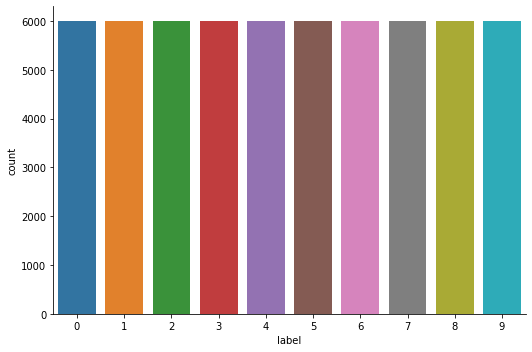

In [10]:
sns.catplot(x='label', data=train, kind='count', height=5, aspect= 1.5)

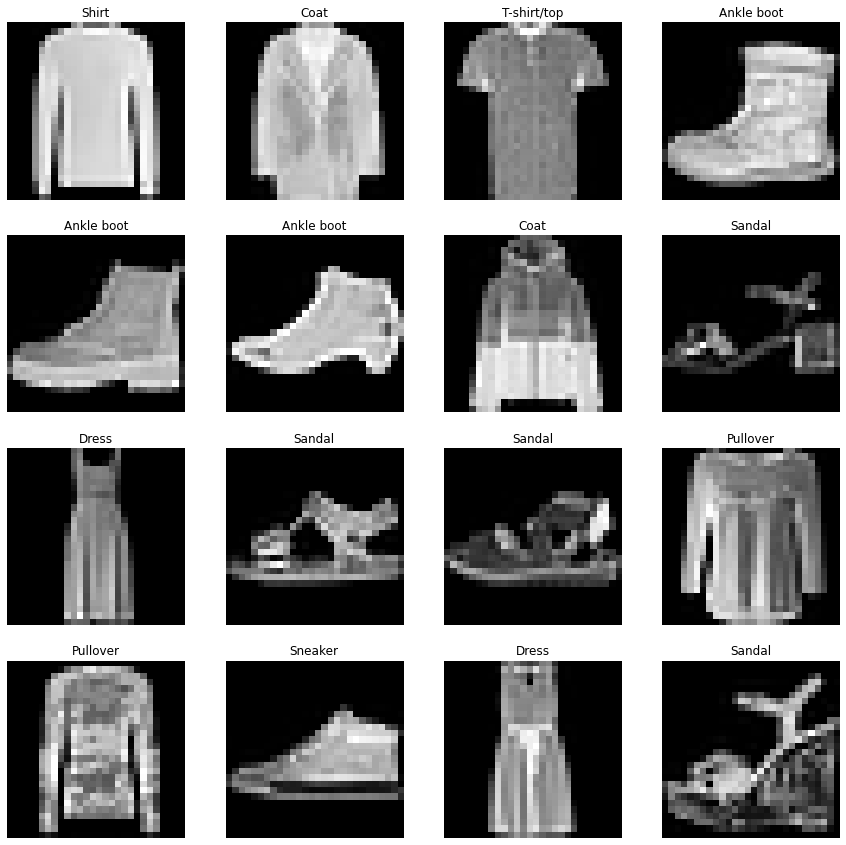

In [11]:
## Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

fig, axes = plt.subplots(4, 4, figsize = (15,15))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = train.drop('label', axis=1).values[index].reshape(28,28)
        cloths = train['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

In [12]:
### Train test split manually without using sklearns since the data was already split into train and test
y_train = train.iloc[:,0]
y_test = test.iloc[:,0]
X_test = test.iloc[:,1:]
X_train= train.iloc[:,1:]


## Normalizing data by dividing with 255 to get range of 0-1
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
test = test.astype("float32")/255


## Convert into categorical data since there are 10 classes of items
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [13]:
### ROC Curve for multiple class
def plt_roc(model,test_x,test_y):

    y_score = model.predict(X_test)
    test_y = label_binarize(test_y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    n_classes = 10

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2


    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['Orchid', 'Yellow', 'cornflowerblue', 'ForestGreen', 'Indigo','Cyan', 'OrangeRed', 'BlueViolet', 'Sienna', 'Red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Fashion Random Forest Classifier ROC')
    plt.legend(loc="lower right")
    plt.figure(figsize=(10, 10))
    plt.show()

In [14]:
#### Confusion Matrix for multiple class

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Model 1

In [24]:
### Model using Softmax and Relu
model = Sequential()
model.add(Flatten(input_shape = (28,28))) ## Flatten converts the shape of 2D image array into 1D array(28*28 = 784)
model.add(Dense(units=128,kernel_initializer = 'uniform', activation = 'relu')) # First Hidden Layer
model.add(Dense(units=64,kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units=24,kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units=10,kernel_initializer = 'uniform', activation = 'softmax')) # Output Layer

In [25]:
model.compile(optimizer = 'rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=50,batch_size = 128,
                    validation_data=(X_test, y_test), verbose=2, callbacks=callback)

Epoch 1/50
469/469 - 3s - loss: 0.9190 - accuracy: 0.6381 - val_loss: 0.6973 - val_accuracy: 0.7292
Epoch 2/50
469/469 - 3s - loss: 0.5657 - accuracy: 0.7978 - val_loss: 0.5810 - val_accuracy: 0.7892
Epoch 3/50
469/469 - 3s - loss: 0.4727 - accuracy: 0.8309 - val_loss: 0.4802 - val_accuracy: 0.8278
Epoch 4/50
469/469 - 2s - loss: 0.4171 - accuracy: 0.8482 - val_loss: 0.4299 - val_accuracy: 0.8451
Epoch 5/50
469/469 - 3s - loss: 0.3804 - accuracy: 0.8627 - val_loss: 0.3853 - val_accuracy: 0.8613
Epoch 6/50
469/469 - 2s - loss: 0.3552 - accuracy: 0.8720 - val_loss: 0.3535 - val_accuracy: 0.8745
Epoch 7/50
469/469 - 3s - loss: 0.3368 - accuracy: 0.8798 - val_loss: 0.3527 - val_accuracy: 0.8755
Epoch 8/50
469/469 - 3s - loss: 0.3210 - accuracy: 0.8851 - val_loss: 0.3675 - val_accuracy: 0.8701
Epoch 9/50
469/469 - 3s - loss: 0.3084 - accuracy: 0.8874 - val_loss: 0.3151 - val_accuracy: 0.8837
Epoch 10/50
469/469 - 3s - loss: 0.2959 - accuracy: 0.8925 - val_loss: 0.3263 - val_accuracy: 0.8792

In [26]:
score = model.evaluate(X_test,y_test)
print("Test Accuracy : %.4f" %(score[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.3271 - accuracy: 0.8880
Test Accuracy : 0.8880


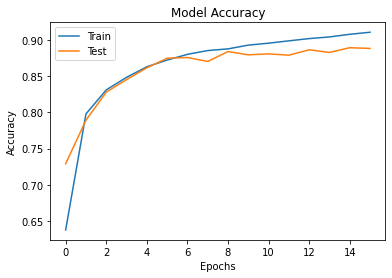

In [27]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

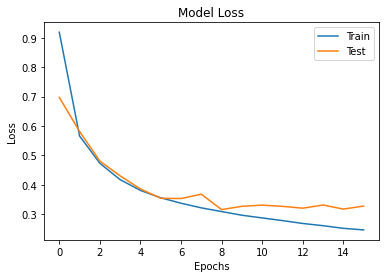

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

CLassification Report
              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1000
           1       0.99      0.98      0.99      1000
           2       0.78      0.87      0.82      1000
           3       0.94      0.87      0.90      1000
           4       0.85      0.80      0.82      1000
           5       0.97      0.95      0.96      1000
           6       0.79      0.63      0.70      1000
           7       0.92      0.95      0.94      1000
           8       0.93      0.98      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



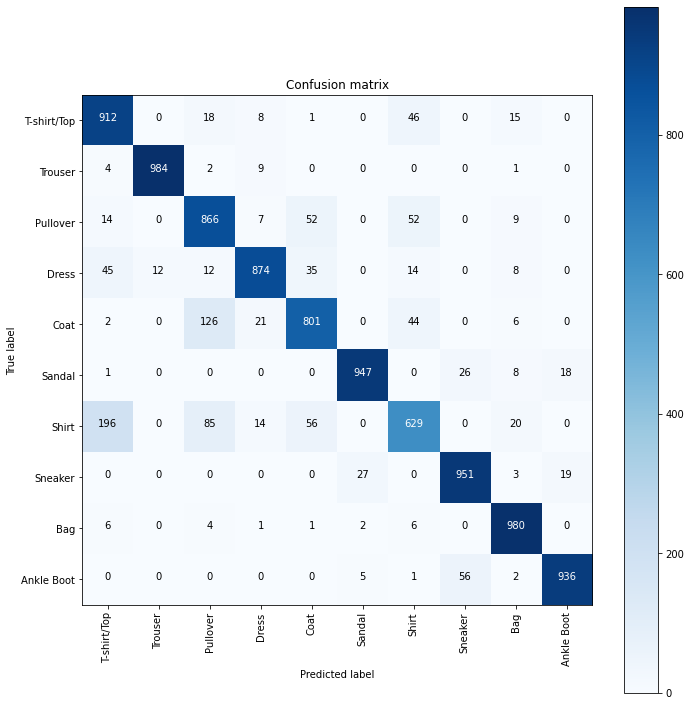

In [29]:

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

print("CLassification Report")

print(classification_report(y_test.argmax(axis=1), Y_pred.argmax(axis=1)))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


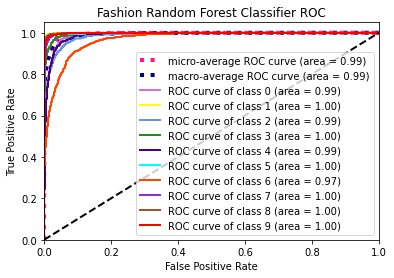

<Figure size 720x720 with 0 Axes>

In [30]:
plt_roc(model,X_test, y_test)

## Model 2

In [32]:
### using scheduled Learning Rate, SGD and Poisson Loss

## Learning rate Scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay( initial_learning_rate=1e-2,
                                                          decay_steps=10000,
                                                          decay_rate=0.9)

##SGD
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

### Poisson Loss
ploss=tf.keras.losses.Poisson(reduction="auto", name="poisson")



model.compile(optimizer = optimizer, loss= ploss, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=50,batch_size = 128,
                    validation_data=(X_test, y_test), verbose=2, callbacks=callback)

Epoch 1/50
469/469 - 3s - loss: 0.1222 - accuracy: 0.9187 - val_loss: 0.1301 - val_accuracy: 0.8942
Epoch 2/50
469/469 - 3s - loss: 0.1213 - accuracy: 0.9213 - val_loss: 0.1298 - val_accuracy: 0.8942
Epoch 3/50
469/469 - 2s - loss: 0.1210 - accuracy: 0.9224 - val_loss: 0.1297 - val_accuracy: 0.8951
Epoch 4/50
469/469 - 2s - loss: 0.1208 - accuracy: 0.9232 - val_loss: 0.1296 - val_accuracy: 0.8960
Epoch 5/50
469/469 - 2s - loss: 0.1207 - accuracy: 0.9237 - val_loss: 0.1296 - val_accuracy: 0.8966
Epoch 6/50
469/469 - 2s - loss: 0.1206 - accuracy: 0.9241 - val_loss: 0.1295 - val_accuracy: 0.8965
Epoch 7/50
469/469 - 2s - loss: 0.1205 - accuracy: 0.9244 - val_loss: 0.1295 - val_accuracy: 0.8977
Epoch 8/50
469/469 - 2s - loss: 0.1204 - accuracy: 0.9250 - val_loss: 0.1295 - val_accuracy: 0.8975
Epoch 9/50
469/469 - 2s - loss: 0.1204 - accuracy: 0.9253 - val_loss: 0.1295 - val_accuracy: 0.8965
Epoch 10/50
469/469 - 2s - loss: 0.1203 - accuracy: 0.9256 - val_loss: 0.1295 - val_accuracy: 0.8969

In [33]:
score = model.evaluate(X_test,y_test)
print("Test Accuracy : %.4f" %(score[1]))


313/313 [==============================] - 1s 2ms/step - loss: 0.1295 - accuracy: 0.8965
Test Accuracy : 0.8965


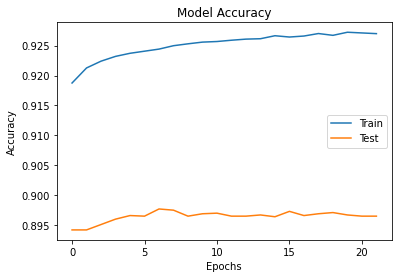

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

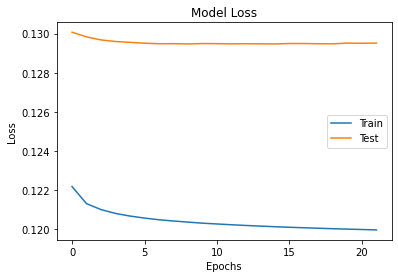

CLassification Report
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.85      0.81      0.83      1000
           3       0.91      0.91      0.91      1000
           4       0.83      0.86      0.85      1000
           5       0.97      0.95      0.96      1000
           6       0.74      0.72      0.73      1000
           7       0.94      0.95      0.95      1000
           8       0.97      0.96      0.97      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



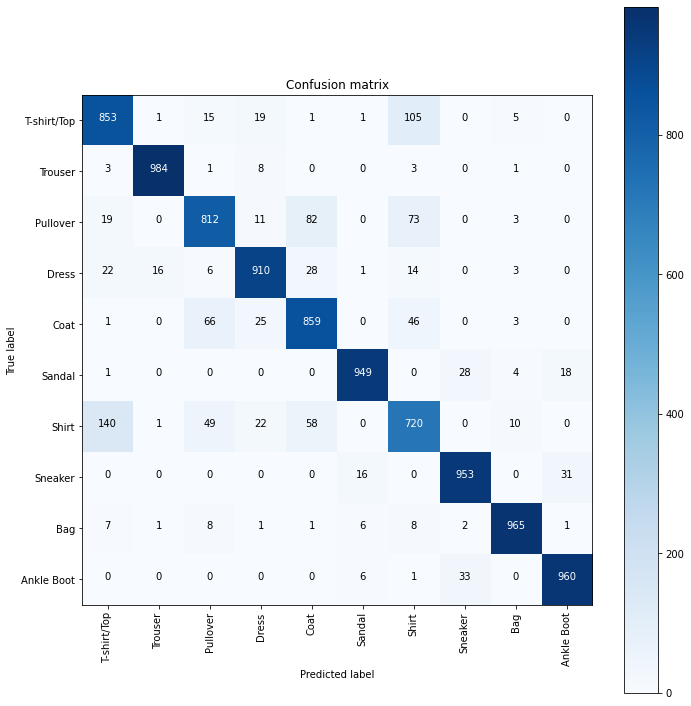

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

print("CLassification Report")

print(classification_report(y_test.argmax(axis=1), Y_pred.argmax(axis=1)))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


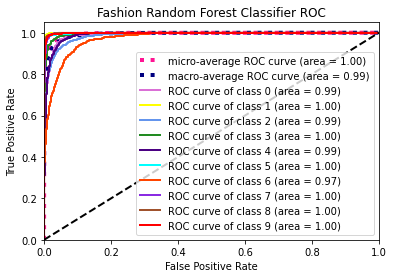

<Figure size 720x720 with 0 Axes>

In [36]:
plt_roc(model,X_test, y_test)